## To Do

- Should we remove patients with a missing Date of Birth? 
- Additional manual, spot-checking of ICD & CPT code category cuts. 
- Re-run RxNav API calls by using "drug_strength" if "StrengthText" missing or if "drug_strength" contains a "mg"
    - Consider whether we want to expand on "mg" to things like "mcg" etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import config
import api_rxnorm
import DatasetCreation
import helper as hlpr

# Load Data

In [3]:
dir = '../data/'
prefix = 'FONNESBECK_'
suffix = '_20151202.csv'

In [4]:
adt = pd.read_csv(dir + prefix + 'ADT' + suffix, encoding='latin1')
adt.columns = adt.columns.str.lower()
adt.head()

,ruid,event,admission_date,event_date,srv_code,chief_complaint,discharge_date
0,50135262,Admit,02/08/2007,02/08/2007,ORT,R FEMUR FX,02/12/2007
1,50135262,Transfer,02/08/2007,02/08/2007,ORT,R FEMUR FX,02/12/2007
2,50135262,Transfer,02/08/2007,02/09/2007,ORT,R FEMUR FX,02/12/2007
3,50135262,Discharge,02/08/2007,02/12/2007,ORT,R FEMUR FX,02/12/2007
4,50135262,Transfer,02/11/2011,02/11/2011,NEU,SEIZURES;HYPERGLYCEMIA,02/23/2011


In [5]:
adt_cms_final = pd.read_pickle(dir + './adt_cms_final.pkl')
adt_cms_final.head()

,ruid,visit_id,admit_date,discharge_date,hospital_day,stay_length,n_transfers,readmit_time,readmit_30d
0,50135262,0,2007-02-08,2007-02-12,2007-02-08,4 days,2,NaT,0
1,50135262,0,2007-02-08,2007-02-12,2007-02-09,4 days,2,NaT,0
2,50135262,0,2007-02-08,2007-02-12,2007-02-10,4 days,2,NaT,0
3,50135262,0,2007-02-08,2007-02-12,2007-02-11,4 days,2,NaT,0
4,50135262,0,2007-02-08,2007-02-12,2007-02-12,4 days,2,NaT,0


In [6]:
cpt = pd.read_csv(dir + prefix + 'CPT' + suffix)
cpt.columns = cpt.columns.str.lower()
cpt.head()

,ruid,cpt_code,event_date
0,50135262,00001,11/28/2004
1,50135262,00005,05/03/2012
2,50135262,00025,02/08/2007
3,50135262,00025,11/16/2004
4,50135262,00030,02/08/2007


In [7]:
icd = pd.read_csv(dir + prefix + 'ICD9' + suffix)
icd.columns = icd.columns.str.lower()
icd.head()

,ruid,icd9_code,event_date
0,50135262,00.40,08/04/2007
1,50135262,00.46,08/04/2007
2,50135262,00.66,08/04/2007
3,50135262,00.81,09/17/2012
4,50135262,00.82,09/17/2012


In [8]:
# can't get this to work (Alvin)
#lab = pd.read_csv(dir + prefix + 'LAB' + suffix) # engine='python' produces a different error
#lab.head()

# I have no trouble opening it in R
#library(data.table)
#df <- fread('/Volumes/AlvinSD/Bios8366/data/FONNESBECK_LAB_20151202.csv')
#write.csv(df, file = '/Volumes/AlvinSD/Bios8366/data/FONNESBECK_LAB2_20151202.csv')

In [9]:
med = pd.read_csv(dir + prefix + 'MED' + suffix)
med.columns = med.columns.str.lower()

# sort values to assist with duplicate removal later
med.sort_values(by=['ruid', 'entry_date', 'drug_name', 'dose_amt'], inplace=True)
med.head()

,ruid,entry_date,drug_name,drug_form,drug_strength,route,dose_amt,drug_freq,duration
1402,50135262,01/09/2005,abilify,pill,15mg,po,1/2 tab,nightly,NaN
1403,50135262,01/09/2005,abilify,NaN,15mg,po,1/2 tab,nightly,NaN
1599,50135262,01/09/2005,amantadine,NaN,100mg,po,NaN,twice daily,NaN
1609,50135262,01/09/2005,amoxicillin,NaN,500mg,po,1 cap,three times daily,NaN
1665,50135262,01/09/2005,asa,NaN,81mg,po,NaN,daily,NaN


In [10]:
phenotype = pd.read_csv(dir + prefix + 'phenotype' + suffix, parse_dates=['DOB', 'DOD'])
phenotype.columns = phenotype.columns.str.lower()
phenotype.head()

,ruid,sex,dob,dod,race
0,50135262,F,1949-09-20,NaT,W
1,50135361,M,1932-02-15,2012-09-09,W
2,50135369,M,1958-05-04,2012-01-23,W
3,50135375,M,1943-05-01,2011-08-18,B
4,50135425,F,1946-10-02,NaT,W


# Phenotype

In [11]:
phenotype.describe(include='all')

,ruid,sex,dob,dod,race
count,8.000000e+03,7957,7957,1358,8000
unique,NaN,3,7049,1119,7
top,NaN,F,1955-03-06 00:00:00,2014-02-22 00:00:00,W
freq,NaN,3986,4,5,5999
first,NaN,NaN,1903-04-17 00:00:00,2004-08-19 00:00:00,NaN
last,NaN,NaN,2014-11-15 00:00:00,2015-06-25 00:00:00,NaN
mean,5.369131e+07,NaN,NaN,NaN,NaN
std,3.663645e+05,NaN,NaN,NaN,NaN
min,5.013526e+07,NaN,NaN,NaN,NaN
25%,5.372991e+07,NaN,NaN,NaN,NaN


In [12]:
uniq = len(np.unique(phenotype.ruid))

print("Shape of phenotype = {shape}. Unique RUIDs = {uniq}.".format(
    shape=phenotype.shape, uniq=uniq))

Shape of phenotype = (8000, 5). Unique RUIDs = 8000.


In [13]:
females = sum(phenotype.sex=='F')
males = sum(phenotype.sex=='M')
unknown = sum(phenotype.sex=='U')
miss = phenotype.sex.isnull().sum()
assert(females + males + unknown + miss == uniq)

print("Females = {f}, Males = {m}, Unknown = {u}, NA = {na}".format(
  f=females, m=males, u=unknown, na=miss))

Females = 3986, Males = 3953, Unknown = 18, NA = 43


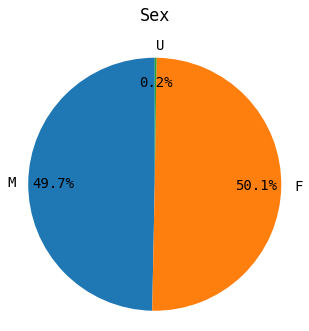

In [15]:
hlpr.pie_chart(['M', 'F', 'U'], phenotype, 'sex', 'Sex', figsize=(5, 5))

In [16]:
asian = sum(phenotype.race=='A')
black = sum(phenotype.race=='B')
hispanic = sum(phenotype.race=='H')
indian = sum(phenotype.race=='I')
other = sum(phenotype.race=='N')
unknown = sum(phenotype.race=='U')
white = sum(phenotype.race=='W')
assert(asian + black + hispanic + indian + other + unknown + white == uniq)

print("Asian = {a}, Black = {b}, Hispanice = {h}, American Indian = {i}, Other = {n}, Unknown = {u}, White = {w}".format( \
  a=asian, b=black, h=hispanic, i=indian, n=other, u=unknown, w=white))

Asian = 94, Black = 1193, Hispanice = 315, American Indian = 8, Other = 50, Unknown = 341, White = 5999


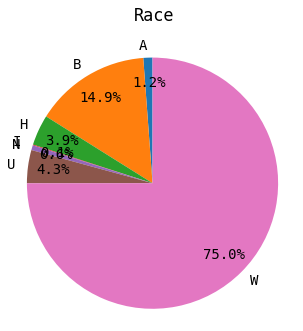

In [17]:
hlpr.pie_chart(['A', 'B', 'H', 'I', 'N', 'U', 'W'], phenotype, 'race', 'Race', figsize=(5, 5))

In [18]:
# missing DOB or sex
potential_removal = phenotype[phenotype.dob.isnull() | phenotype.sex.isnull()]
potential_removal

,ruid,sex,dob,dod,race
138,53727820,NaN,NaT,NaT,U
363,53728072,NaN,NaT,NaT,U
537,53728274,NaN,NaT,NaT,U
711,53728472,NaN,NaT,NaT,U
811,53728579,NaN,NaT,NaT,U
832,53728602,NaN,NaT,NaT,U
906,53728684,NaN,NaT,NaT,U
955,53728740,NaN,NaT,NaT,U
1192,53729008,NaN,NaT,NaT,U
1318,53729141,NaN,NaT,NaT,U


In [19]:
potential_removal.shape

(43, 5)

In [20]:
phenotype.to_pickle(dir + './phenotype.pkl')

# ICD Codes

In [21]:
uniq = len(np.unique(icd.ruid))
codes = set(icd.icd9_code)

print("Shape of ICD = {shape}. Unique RUIDs = {uniq}. Unique ICD9 Codes = {codes}.".format(
    shape=icd.shape, uniq=uniq, codes=len(codes)))

Shape of ICD = (2052067, 3). Unique RUIDs = 7935. Unique ICD9 Codes = 12423.


In [22]:
# create a new column of numeric version of codes, making strings NaN
icd['code_num'] = pd.to_numeric(icd.icd9_code, errors='coerce')

In [23]:
icd['code_cat'] = pd.cut(icd.code_num, bins=[0, 1, 140, 240, 280, 290, 320, 
                                              390, 460, 520, 580, 630, 
                                              680, 710, 740, 760, 780, 800, 1000], 
                         right=False, # closed on the left, non-inclusive on the right
                         labels=['proc', 'dx_infection', 'dx_neoplasm', 'dx_endocrine', 'dx_blood', 'dx_mental', 'dx_nervous', 
                                 'dx_circulatory', 'dx_respiratory', 'dx_digestive', 'dx_gu', 'dx_obstetric', 
                                 'dx_skin', 'dx_muscskel', 'dx_congenital', 'dx_perinatal', 'dx_symptoms', 'dx_injury'])

icd.code_cat = np.where(icd.icd9_code.str.contains('V'), 'visit', icd.code_cat)
icd.code_cat = np.where(icd.icd9_code.str.contains('E'), 'dx_external', icd.code_cat)

In [24]:
icd.head()

,ruid,icd9_code,event_date,code_num,code_cat
0,50135262,00.40,08/04/2007,0.40,proc
1,50135262,00.46,08/04/2007,0.46,proc
2,50135262,00.66,08/04/2007,0.66,proc
3,50135262,00.81,09/17/2012,0.81,proc
4,50135262,00.82,09/17/2012,0.82,proc


In [25]:
icd.tail()

,ruid,icd9_code,event_date,code_num,code_cat
2052062,53736423,77,04/25/2006,77.0,dx_infection
2052063,53736423,774.6,04/23/2006,774.6,dx_perinatal
2052064,53736423,V30.00,04/23/2006,NaN,visit
2052065,53736423,V50.2,04/23/2006,NaN,visit
2052066,53736423,V50.2,04/24/2006,NaN,visit


In [26]:
dx_dict = {}
for dx in set(icd.code_cat):
    dx_dict[dx] = sum(icd.code_cat==str(dx))

assert(sum(dx_dict.values()) == icd.shape[0])

In [27]:
dx_dict

{'dx_nervous': 86283,
 'dx_mental': 79404,
 'dx_injury': 78319,
 'dx_blood': 76572,
 'dx_muscskel': 100649,
 'dx_digestive': 87582,
 'dx_external': 13521,
 'dx_circulatory': 226565,
 'dx_respiratory': 109354,
 'dx_perinatal': 24061,
 'dx_gu': 95505,
 'dx_congenital': 34379,
 'dx_infection': 145279,
 'dx_symptoms': 283718,
 'visit': 255132,
 'dx_skin': 26707,
 'dx_obstetric': 19746,
 'dx_endocrine': 162164,
 'proc': 38203,
 'dx_neoplasm': 108924}

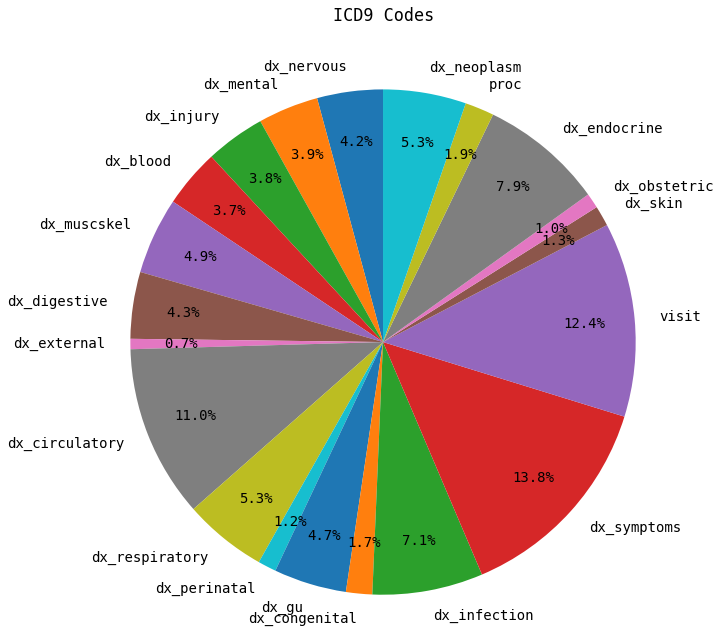

In [29]:
hlpr.pie_chart(dx_dict.keys(), icd, 'code_cat', 'ICD9 Codes', figsize = (10, 10))

In [35]:
# add counts of ICD9 categories for each day/patient combination
icd_wide = icd.copy()
icd_wide = (icd_wide.drop(columns=['icd9_code', 'code_num'])
                    .groupby(['ruid', 'event_date', 'code_cat'])
                    .size()
                    .unstack()
                    .fillna(0))

In [36]:
# add 'icd_' prefix to all columns
cols = icd_wide.columns[~icd_wide.columns.str.contains('ruid|event_date')]
icd_wide.rename(columns = dict(zip(cols, 'icd_' + cols)), inplace=True)
icd_wide.head()

code_cat             icd_dx_blood  icd_dx_circulatory  icd_dx_congenital  \
ruid     event_date                                                        
50135262 01/09/2005           0.0                 0.0                0.0   
         02/08/2007           0.0                 2.0                0.0   
         02/09/2007           0.0                 2.0                0.0   
         02/10/2007           0.0                 0.0                0.0   
         02/11/2007           0.0                 0.0                0.0   

code_cat             icd_dx_digestive  icd_dx_endocrine  icd_dx_external  \
ruid     event_date                                                        
50135262 01/09/2005               0.0               0.0              0.0   
         02/08/2007               0.0               3.0              1.0   
         02/09/2007               0.0               1.0              0.0   
         02/10/2007               0.0               1.0              0.0   
         02/11/2007               0.0               1.0              0.0   

code_cat             icd_dx_gu  icd_dx_infection  icd_dx_injury  \
ruid     event_date                                               
50135262 01/09/2005        0.0               0.0            0.0   
         02/08/2007        0.0               2.0            5.0   
         02/09/2007        0.0               2.0            4.0   
         02/10/2007        0.0               0.0            0.0   
         02/11/2007        0.0               0.0            0.0   

code_cat             icd_dx_mental  icd_dx_muscskel  icd_dx_neoplasm  \
ruid     event_date                                                    
50135262 01/09/2005            0.0              0.0              0.0   
         02/08/2007            0.0              1.0              0.0   
         02/09/2007            0.0              0.0              0.0   
         02/10/2007            0.0              0.0              0.0   
         02/11/2007            0.0              0.0              0.0   

code_cat             icd_dx_nervous  icd_dx_obstetric  icd_dx_perinatal  \
ruid     event_date                                                       
50135262 01/09/2005             0.0               0.0               0.0   
         02/08/2007             1.0               0.0               0.0   
         02/09/2007             0.0               0.0               0.0   
         02/10/2007             0.0               0.0               0.0   
         02/11/2007             0.0               0.0               0.0   

code_cat             icd_dx_respiratory  icd_dx_skin  icd_dx_symptoms  \
ruid     event_date                                                     
50135262 01/09/2005                 0.0          0.0              1.0   
         02/08/2007                 1.0          0.0              3.0   
         02/09/2007                 0.0          0.0              0.0   
         02/10/2007                 0.0          0.0              2.0   
         02/11/2007                 0.0          0.0              0.0   

code_cat             icd_proc  icd_visit  
ruid     event_date                       
50135262 01/09/2005       0.0        0.0  
         02/08/2007       0.0        4.0  
         02/09/2007       0.0        2.0  
         02/10/2007       0.0        0.0  
         02/11/2007       0.0        0.0

In [37]:
icd_wide.reset_index(inplace=True)
icd_wide.head()

code_cat,ruid,event_date,icd_dx_blood,icd_dx_circulatory,icd_dx_congenital,icd_dx_digestive,icd_dx_endocrine,icd_dx_external,icd_dx_gu,icd_dx_infection,...,icd_dx_muscskel,icd_dx_neoplasm,icd_dx_nervous,icd_dx_obstetric,icd_dx_perinatal,icd_dx_respiratory,icd_dx_skin,icd_dx_symptoms,icd_proc,icd_visit
0,50135262,01/09/2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50135262,02/08/2007,0.0,2.0,0.0,0.0,3.0,1.0,0.0,2.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,4.0
2,50135262,02/09/2007,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,50135262,02/10/2007,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,50135262,02/11/2007,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
icd_wide.tail()

code_cat,ruid,event_date,icd_dx_blood,icd_dx_circulatory,icd_dx_congenital,icd_dx_digestive,icd_dx_endocrine,icd_dx_external,icd_dx_gu,icd_dx_infection,...,icd_dx_muscskel,icd_dx_neoplasm,icd_dx_nervous,icd_dx_obstetric,icd_dx_perinatal,icd_dx_respiratory,icd_dx_skin,icd_dx_symptoms,icd_proc,icd_visit
574577,53736422,12/06/2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
574578,53736422,12/25/2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
574579,53736423,04/23/2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
574580,53736423,04/24/2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
574581,53736423,04/25/2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [39]:
icd_wide['event_date'] = pd.to_datetime(icd_wide['event_date'])

In [ ]:
icd_wide.to_pickle(dir + 'icd_wide.pkl')

# CPT Codes

In [40]:
cpt.tail()

,ruid,cpt_code,event_date
3827383,53736423,86850,04/25/2006
3827384,53736423,86880,04/25/2006
3827385,53736423,86900,04/25/2006
3827386,53736423,86901,04/25/2006
3827387,53736423,90744,04/23/2006


In [41]:
uniq = len(np.unique(cpt.ruid))
codes = set(cpt.cpt_code)

print("Shape of CPT = {shape}. Unique RUIDs = {uniq}. Unique CPT Codes = {codes}.".format(
    shape=cpt.shape, uniq=uniq, codes=len(codes)))

Shape of CPT = (3827388, 3). Unique RUIDs = 7891. Unique CPT Codes = 7274.


In [42]:
# are any non-numeric CPT codes present - yes!
np.unique(cpt.cpt_code)

array([' J751', '00001', '00002', ..., 'V5363', 'V5364', 'Y1405'],
      dtype=object)

In [43]:
# create a new column of numeric version of codes, making strings NaN
cpt['code_num'] = pd.to_numeric(cpt.cpt_code, errors='coerce')

In [44]:
cpt['code_cat'] = pd.cut(cpt.code_num, bins=[0, 99, # expired codes
                                             100-0.01, 1999, # anethesia
                                             10000-0.01, 69990, # surgery
                                             70000-0.01, 79999, # radiology
                                             80000-0.01, 89398, # pathology & laboratory
                                             90281-0.01, 99099, # medicine
                                             99100-0.01, 99150, # anesthesia
                                             99151-0.01, 99199, # medicine
                                             99201-0.01, 99499, # evaluation & management
                                             99500-0.01, 99607, # medicine
                                             99608-0.01, 100000, # unknown2
                                             ],
                          # by default, it doesn't include value on the left, so -0.01 added
                          right=True, # inclusive on the right
                          # labels must be unique in the pandas cut() function
                          labels=['expired', 'gap0',
                                  'anesthesia1', 'gap1', 
                                  'surgery', 'gap2',
                                  'radiology', 'gap3', 
                                  'path_lab', 'gap4', 
                                  'medicine1', 'gap5',
                                  'anesthesia2', 'gap6',
                                  'medicine2', 'gap7',
                                  'eval_manage', 'gap8',
                                  'medicine3', 'gap9',
                                  'unknown1'
                                 ])

# remove numbers from labels
cpt.code_cat = cpt.code_cat.str.replace('\d+', '', regex=True)

# for Category 2 & 3 CPT codes (i.e., those that include a letter rather than all numbers), 
# marks as "modifier" (the CPT terminology), which are optional for billing purposes
cpt.code_cat = np.where(np.isnan(cpt.code_num), 'modifier', cpt.code_cat)

In [45]:
cpt.head()

,ruid,cpt_code,event_date,code_num,code_cat
0,50135262,00001,11/28/2004,1.0,expired
1,50135262,00005,05/03/2012,5.0,expired
2,50135262,00025,02/08/2007,25.0,expired
3,50135262,00025,11/16/2004,25.0,expired
4,50135262,00030,02/08/2007,30.0,expired


In [46]:
cpt.tail()

,ruid,cpt_code,event_date,code_num,code_cat
3827383,53736423,86850,04/25/2006,86850.0,path_lab
3827384,53736423,86880,04/25/2006,86880.0,path_lab
3827385,53736423,86900,04/25/2006,86900.0,path_lab
3827386,53736423,86901,04/25/2006,86901.0,path_lab
3827387,53736423,90744,04/23/2006,90744.0,medicine


In [47]:
# what are the 'unknown' values?
np.unique(cpt[cpt.code_cat=='unknown']['cpt_code'])

array(['99999'], dtype=object)

I couldn't find 99999 anywhere - perhaps this just means missing & should be removed?

In [48]:
# what are the 'gap' values?
np.unique(cpt[cpt.code_cat=='gap']['cpt_code'])

array(['01999.1', '01999.2', '01999.3', '01999.4', '01999.5', '01999.6',
       '01999.7', '01999.8', '89399', '9999'], dtype=object)

I've never seen decimal places in a CPT code, so we could either label these as modifiers or just remove them (similar to 9999, which isn't a correct CPT code as it only has 4 digits).  

In [49]:
# replace "gap" with unknown
cpt.code_cat = np.where(cpt.code_cat=='gap', 'unknown', cpt.code_cat)

In [50]:
code_dict = {}
for code in set(cpt.code_cat):
    code_dict[code] = sum(cpt.code_cat==str(code))

assert(sum(code_dict.values()) == cpt.shape[0])

code_dict

{'unknown': 5964,
 'medicine': 474569,
 'anesthesia': 6526,
 'eval_manage': 447503,
 'path_lab': 1813333,
 'surgery': 179513,
 'expired': 81986,
 'modifier': 625824,
 'radiology': 192170}

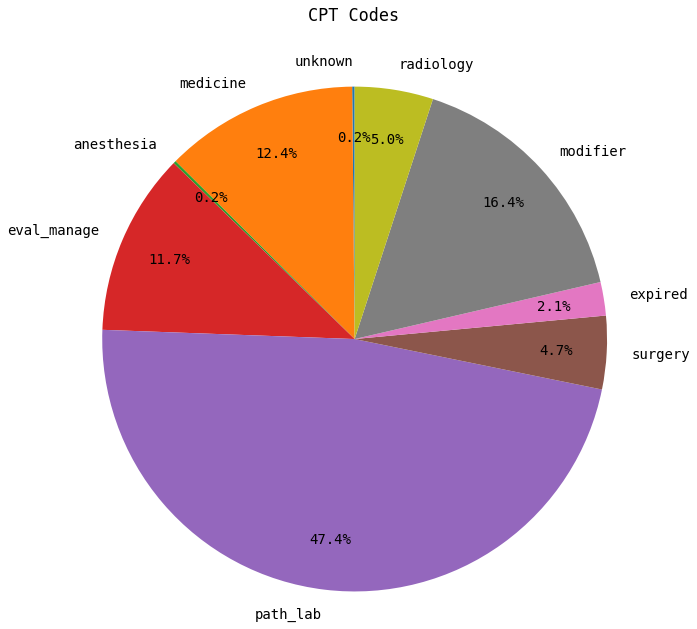

In [51]:
hlpr.pie_chart(code_dict.keys(), cpt, 'code_cat', 'CPT Codes', figsize = (10, 10))

In [52]:
# add counts of CPT categories for each day/patient combination
cpt_wide = cpt.copy()
cpt_wide = (cpt_wide.drop(columns=['cpt_code', 'code_num'])
                    .groupby(['ruid', 'event_date', 'code_cat'])
                    .size()
                    .unstack()
                    .fillna(0))

In [53]:
# add 'cpt_' prefix to all columns
cols = cpt_wide.columns[~cpt_wide.columns.str.contains('ruid|event_date')]
cpt_wide.rename(columns = dict(zip(cols, 'cpt_' + cols)), inplace=True)
cpt_wide.head()

code_cat             cpt_anesthesia  cpt_eval_manage  cpt_expired  \
ruid     event_date                                                 
50135262 01/09/2005             0.0              1.0          0.0   
         02/08/2007             0.0              1.0          2.0   
         02/09/2007             0.0              2.0          1.0   
         02/10/2007             0.0              1.0          0.0   
         02/11/2007             0.0              1.0          0.0   

code_cat             cpt_medicine  cpt_modifier  cpt_path_lab  cpt_radiology  \
ruid     event_date                                                            
50135262 01/09/2005           1.0           0.0           0.0            0.0   
         02/08/2007           4.0           2.0          10.0            4.0   
         02/09/2007           0.0           3.0           9.0            5.0   
         02/10/2007           7.0           2.0           2.0            0.0   
         02/11/2007           2.0           1.0           2.0            0.0   

code_cat             cpt_surgery  cpt_unknown  
ruid     event_date                            
50135262 01/09/2005          0.0          0.0  
         02/08/2007          0.0          0.0  
         02/09/2007          2.0          0.0  
         02/10/2007          0.0          0.0  
         02/11/2007          0.0          0.0

In [54]:
cpt_wide.reset_index(inplace=True)
cpt_wide.head()

code_cat,ruid,event_date,cpt_anesthesia,cpt_eval_manage,cpt_expired,cpt_medicine,cpt_modifier,cpt_path_lab,cpt_radiology,cpt_surgery,cpt_unknown
0,50135262,01/09/2005,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,50135262,02/08/2007,0.0,1.0,2.0,4.0,2.0,10.0,4.0,0.0,0.0
2,50135262,02/09/2007,0.0,2.0,1.0,0.0,3.0,9.0,5.0,2.0,0.0
3,50135262,02/10/2007,0.0,1.0,0.0,7.0,2.0,2.0,0.0,0.0,0.0
4,50135262,02/11/2007,0.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0


In [55]:
cpt_wide.tail()

code_cat,ruid,event_date,cpt_anesthesia,cpt_eval_manage,cpt_expired,cpt_medicine,cpt_modifier,cpt_path_lab,cpt_radiology,cpt_surgery,cpt_unknown
576803,53736422,12/06/2006,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576804,53736422,12/25/2007,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
576805,53736423,04/23/2006,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
576806,53736423,04/24/2006,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
576807,53736423,04/25/2006,0.0,0.0,1.0,0.0,0.0,7.0,0.0,0.0,0.0


In [ ]:
cpt_wide['event_date'] = pd.to_datetime(cpt_wide['event_date'])

In [ ]:
cpt_wide.to_pickle(dir + 'cpt_wide.pkl')

# Medications

In [ ]:
med[60:80]

In [ ]:
med[-10:]

There are significant duplicates of numeric rows where a ".00000" is added to `dose_amt`. Given that this is likely a coding error (e.g., even a vaccine was administered at 5 and 5.00000 for the same patient on the same, which wouldn't happen), I'm removing all rows with the ".00000" in the dose by first removing the ".00000" then looking for duplicates. I already sorted values during loading of data. 

In [ ]:
med2 = med.copy()
med2.dose_amt = med2.dose_amt.str.replace('.00000', '')
med2.drop_duplicates(inplace=True)

In [ ]:
print("Removed {diff} of {orig} rows ({perc}%).".format(
    diff=med.shape[0]-med2.shape[0], orig=med.shape[0], 
    perc=round((med.shape[0]-med2.shape[0])/med.shape[0]*100, 2)))
med2.shape

In [ ]:
# make new columns to match api for RxNorm
med2.rename(columns={'drug_name': 'DrugNameWithoutDose',
                    'drug_form': 'DosageForm'}, 
            inplace=True)

# inconsistencies in whether dose_amt vs. drug_strength contains the actual strength
# if drug_strength is missing or if dose_amt contains an "mg" use the dose_amt veriable
med2['StrengthText'] = np.where((med2.drug_strength.isnull() | 
                                 med2.dose_amt.str.contains('mg', case=False)), 
                                med2.dose_amt,
                                med2.drug_strength)

# need to add a blank 'DrugUnit' as it's already included in 'dose_amt'
med2['DrugUnit'] = np.NaN

med2.head()

### Convert Strings to Standardized RxNorm Concept Unique Identifiers (CUIs)

In [ ]:
# only needs to be run once
#DatasetCreation.structured_elements2rxcui(med2)

In [ ]:
cuis = pd.read_csv(config.out_dir + 'structured_elements_to_rxcui.csv')
print(cuis.shape)
cuis.head()

### Convert RxNorm CUIs to MeSH Drug Classes

In [ ]:
# only needs to be run once
#DatasetCreation.cui2class(cuis)

In [ ]:
# load classes corresponding to each cui
classes = pd.read_csv(config.out_dir + 'cui2class.csv')
print(classes.shape)

# drop rows with no corresponding categories (i.e., must contain rxcui & at least 1 category)
classes.dropna(thresh=2, inplace=True)
print(classes.shape)
classes.head()

In [ ]:
classes.tail()

### Combine All Medication Information

In [ ]:
# add "unique_combo" column to original meds for merging
med2['unique_combo'] = api_rxnorm.make_string(med2)
med2.head()

In [ ]:
# replace "%20" with space (because not making API calls here)
med2.drop(columns='full', inplace=True)
med2.unique_combo = med2.unique_combo.str.replace('%20', ' ')

In [ ]:
med2[:10]

In [ ]:
med2[-10:]

In [ ]:
# add just first rxcui (for now)
med_cuis = (med2[['ruid', 'entry_date', 'unique_combo']]
            .merge(cuis[['unique_combo', 'rxcui1']], 
                   how='left', 
                   on='unique_combo'))
med_cuis.head()

In [ ]:
med_cuis.tail()

In [ ]:
# rename rxcui for merge
med_cuis.rename(columns={'rxcui1': 'rxcui'}, inplace=True)

med_classes = med_cuis.merge(classes, how='left', on='rxcui')
med_classes.head()

In [ ]:
med_classes.tail()

In [ ]:
med_classes.shape

In [ ]:
# break dataframe into subsections to reduce memory burden (& increase speed)
batch_size = 1000000

batches = [med_classes[i * batch_size:(i + 1) * batch_size] \
           for i in range((len(med_classes) + batch_size - 1) // batch_size)]

In [ ]:
if config.print_status:
    counter = 0
    print('Created ' + str(len(batches)) + ' batches.')
    
med_classes_long = pd.DataFrame()

for i in range(len(batches)):
    if config.print_status:
        counter += 1
        print('Starting batch # ' + str(counter))
    
    # melt data frame so all categories collapsed into 1 column
    temp = pd.melt(batches[i], id_vars=['ruid', 'entry_date', 'unique_combo', 'rxcui'])
    
    # append to existing dataframe
    med_classes_long = med_classes_long.append(temp, sort=True)

In [ ]:
# melt data frame so all categories collapsed into 1 column
med_classes = pd.melt(med_classes, id_vars=['ruid', 'entry_date', 'unique_combo', 'rxcui'])
# drop values where category was missing (which is primarily done for cat2 & higher)
med_classes.dropna(inplace=True)
med_classes.head()

In [ ]:
med_classes.shape

In [ ]:
# This file contains the unique medications for each patient-day along with the
# first (best) RxCUI and all MeSH classess associated with that first CUI.
# Because an RxCUI can have multiple classes, the "variable" column indicates 
# which category the value belonged to (note: this is not ranked, all categories 
# are equally representative for the RxCUI)

#med_classes.to_pickle(dir + 'med_classes.pkl')
med_classes.to_csv(dir + 'med_classes.csv')

### Drop RUIDs of Patients not in Final Cohort

In [ ]:
med_classes = pd.read_pickle(dir + './med_classes.pkl')
med_classes.head()

In [ ]:
final_ruids = adt_cms_final.ruid.unique()
len(final_ruids)

In [ ]:
# break dataframe into subsections to prevent timeout
batch_size = 500
ruids = [final_ruids[i * batch_size:(i + 1) * batch_size] \
         for i in range((len(final_ruids) + batch_size - 1) // batch_size)]

In [ ]:
if config.print_status:
    counter = 0
    print('Created ' + str(len(ruids)) + ' batches.')
    
med_classes_final_ruids = pd.DataFrame()

for i in range(len(ruids)):
    if config.print_status:
        counter += 1
        print('Starting batch # ' + str(counter))
    
    temp = med_classes[med_classes['ruid'].isin(ruids[i])]
    
    temp = (temp.drop(columns=['rxcui', 'variable'])
                .groupby(['ruid', 'entry_date', 'value'])
                .size()
                .unstack()
                .fillna(0))
    
    med_classes_final_ruids = med_classes_final_ruids.append(temp, sort=True)

In [ ]:
# add 'med_' prefix to all columns
cols = med_classes_final_ruids.columns[~med_classes_final_ruids.columns.str.contains('ruid|event_date')]
med_classes_final_ruids.rename(columns = dict(zip(cols, 'med_' + cols)), inplace=True)
med_classes_final_ruids.head()

In [ ]:
med_classes_final_ruids.shape

In [ ]:
med_classes_final_ruids.reset_index(inplace=True)

In [ ]:
med_classes_final_ruids.head()

In [ ]:
med_classes_final_ruids.tail()

In [ ]:
len(med_classes_final_ruids.ruid.unique())

In [ ]:
med_classes_final_ruids['entry_date'] = pd.to_datetime(med_classes_final_ruids['entry_date'])

In [ ]:
# SAVE
med_classes_final_ruids.to_pickle(dir + 'med_classes_final_ruids.pkl')